# Using PTFM package
This notebook provides a testing ground for the `ptfm` package. It provides functions used to generate synthetic data according to a variety of generating processes (DGPs). Our `ptfm` package provides routines to recover factors and loadings given the assumed DGP. Examples are divided according to the DGP used allowing for easy comparison across methods and settings.

In [12]:
# Import necessary packages used throughout session
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import toeplitz

# Import updated PTFM package and standard PLS for comparison
import ptfm
from sklearn.cross_decomposition import PLSRegression

# Handy function to construct pretty ranges for plotting
def variable_plot_range(x, percentage = 0.05):
    min_value = np.min(x)
    max_value = np.max(x)
    range_value = max_value - min_value
    adjustment = percentage * range_value
    return (min_value - adjustment, max_value + adjustment)

## Standard specification
The standard and simpliest specification of the Probabilistic Targeted Factor Model (PTFM) is
$$
\begin{align*}
    X & = FP' + E_x \\
    Y & = FQ' + E_y
\end{align*}
$$
where $X$ is a $T \times p$ matrix of features, $Y$ is a $T \times q$ matrix of target variables of interest, $F$ is a $T \times k$ matrix of factors or scores, $P$ is the $p \times k$ matrix of loadings in the feature equation, and $Q$ is the $q \times k$ matrix of loadings in the target equation. It assumed that the co-movements in $X$ and $Y$ are driven by a set of low-dimensional factors such that $k \ll p$. $E_X$ is a $T \times p$ matrix of disturbances with each element distributed according to $\text{Normal}(0, \sigma_x^2)$ and $E_Y$ is a $T \times q$ matrix of disturbances with each element distributed according to $\text{Normal}(0, \sigma_y^2)$. $E_X$ and $E_Y$ are assumed uncorrelated throughout all examples. We generate variables using a prior variance $V_F = I_k$, an identity of order $k$.

In [13]:
# Generating function
def generate_data_simple(T, p, q, k, sigma_x, sigma_y, seed_value=None):
    """
    Input: 
        T          - Sample size
        p          - Number of features
        q          - Number of targets
        k          - Number of factors (components)
        sigma_x    - Scale of features
        sigma_y    - Scale of targets
        seed_value - If None, random seed used every time. Otherwise, seed passed to RNG
    Output:
        X - Features (T x p matrix)
        Y - Targets  (T x q matrix)
        F - Scores   (T x k matrix)
        P - Loadings of feature equation (p x k matrix)
        Q - Loadings of target equation (q x k matrix)
    """
    # Generate latent variables
    rng = np.random.default_rng(seed=seed_value)
    F = rng.normal(size = [T, k])
    
    # Generate loadings
    P = rng.normal(size = [p, k])
    Q = rng.normal(size = [q, k])
    
    # Generate predictor and response variables with added noise
    X = F @ P.T + rng.normal(scale = sigma_x, size = [T, p])
    Y = F @ Q.T + rng.normal(scale = sigma_y, size = [T, q])
    
    return X, Y, F, P, Q

# Simulation control parameters
T, p, q, k = 200, 10, 3, 2
true_sigma_x, true_sigma_y = 1.0, 1.0
seed_value = None

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true = generate_data_simple(T, p, q, k, true_sigma_x, true_sigma_y, seed_value)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls_simple = pls.predict(X)

# Apply our PTFM EM method
ptfm_simple = ptfm.ProbabilisticTFM(n_components=k)
ptfm_simple.fit(X, Y, standardize = False, track_r2 = True)
Y_fitted_ptfm_simple = ptfm_simple.fitted(X, Y, standardize = False)

# Compute R-squared for both models and compare them
r2_pls_simple = r2_score(Y, Y_fitted_pls_simple, multioutput = "raw_values")
r2_ptfm_simple = r2_score(Y, Y_fitted_ptfm_simple, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls_simple, "R^2 Probabilistic PLS": r2_ptfm_simple}
print(r2_results)

{'R^2 PLS': array([0.69765733, 0.53726346, 0.64788777]), 'R^2 Probabilistic PLS': array([0.79904052, 0.70213656, 0.76035384])}


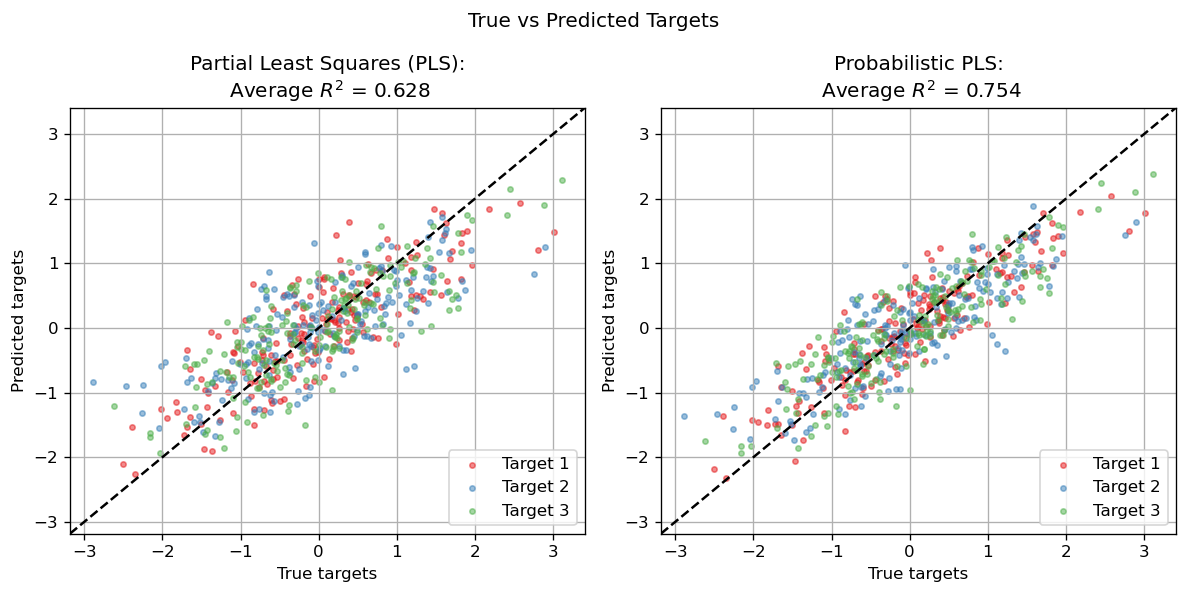

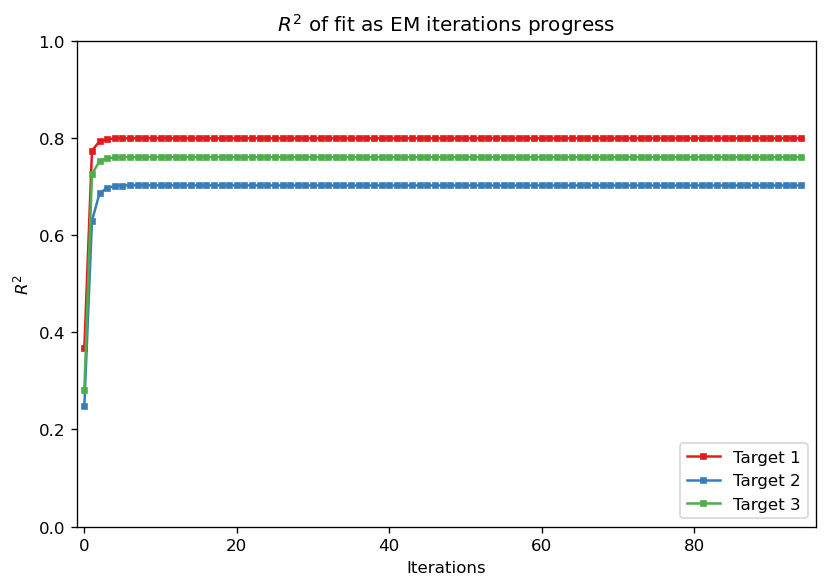

In [14]:
# Visualize comparison between methods
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_fitted_pls_simple, Y_fitted_ptfm_simple])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls_simple[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls_simple):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfm_simple[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfm_simple):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFM
max_iterations = ptfm_simple.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfm_simple.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## System covariance
The paper shows that the recovery of factors and loadings is robust to the covariance process of the features and targets as long as the data is standardized prior to processing. By allowing more complicated processes for $E_X$ and $E_Y$, we can test the robustness of our framework to misspecified data-generating processes. This example shows that the PTFM setup does not assume independent errors as a correct distributional assumption, but rather uses this framework to provide probabilistic targeted factor extraction.

Let $E_{X, t}$ and $E_{Y, t}$ represent an arbitrary row of $E_X$ and $E_Y$, respectively. We can allow for $E_{X, t} \sim \text{Normal}(0_p, \Sigma_X)$ and $E_{Y, t} \sim \text{Normal}(0_q, \Sigma_Y)$ for general covariance matrices $\Sigma_X$ and $\Sigma_Y$. We provide functions that generate $X$ and $Y$ assuming $\Sigma_X$ and $\Sigma_Y$ have the following generic Toeplitz structure:
$$
\Sigma_X = \begin{bmatrix} \sigma_{x, 1} & \sigma_{x, 2} & \cdots & \sigma_{x, p} \\ \sigma_{x, 2} & \sigma_{x, 1} & \cdots & \sigma_{x, p-1} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{x, p} & \sigma_{x, p-1} & \cdots & \sigma_{x, 1} \end{bmatrix} \quad \text{and} \quad
\Sigma_Y = \begin{bmatrix} \sigma_{y, 1} & \sigma_{y, 2} & \cdots & \sigma_{y, q} \\ \sigma_{y, 2} & \sigma_{y, 1} & \cdots & \sigma_{y, q-1} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{y, q} & \sigma_{y, q-1} & \cdots & \sigma_{y, 1} \end{bmatrix}
$$
for sequences $\sigma_{x} = (\sigma_{x, 1}, \ldots, \sigma_{x, p})$ and $\sigma_{y} = (\sigma_{y, 1}, \ldots, \sigma_{y, q})$. In our example, we set $\sigma_{x, j} = \rho_x^{j-1}$ for $j = 1, \ldots, p$ and $\sigma_{y, j} = \rho_y^{j-1}$ for $j = 1, \ldots, q$, given correlation parameters $\rho_x$ and $\rho_y$.

In [15]:
# Generating function
def generate_data_system(T, p, q, k, sigma_x, sigma_y, seed_value=None):
    """
    Input: 
        T          - Sample size
        p          - Number of features
        q          - Number of targets
        k          - Number of factors (components)
        sigma_x    - Vector with components for Toeplitz structure in covariance matrix of features (size T)
        sigma_y    - Vector with components for Toeplitz structure in covariance matrix of targets (size T)
        seed_value - If None, random seed used every time. Otherwise, seed passed to RNG
    Output:
        X       - Features (T x p matrix)
        Y       - Targets  (T x q matrix)
        F       - Scores   (T x k matrix)
        P       - Loadings of feature equation (p x k matrix)
        Q       - Loadings of target equation (q x k matrix)
        Sigma_x - Covariance matrix of features
        Sigma_y - Covariance matrix of targets
    """
    # Generate latent variables
    rng = np.random.default_rng(seed=seed_value)
    F = rng.normal(size = [T, k])
    
    # Generate loadings
    P = rng.normal(size = [p, k])
    Q = rng.normal(size = [q, k])
    
    # Construct covariance matrices using Toeplitz structure
    Sigma_x = toeplitz(sigma_x)
    Sigma_y = toeplitz(sigma_y)

    # Generate predictor and response variables with added noise
    X = F @ P.T + rng.multivariate_normal(mean = np.zeros(p), cov = Sigma_x, size = T)
    Y = F @ Q.T + rng.multivariate_normal(mean = np.zeros(q), cov = Sigma_y, size = T)
    
    return X, Y, F, P, Q, Sigma_x, Sigma_y

# Simulation control parameters
rho_x, rho_y = 0.5, 0.5
true_sigma_x = np.array([rho_x**j for j in range(p)])
true_sigma_y = np.array([rho_y**j for j in range(q)])
seed_value = None

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true, Sigma_x, Sigma_y = generate_data_system(T, p, q, k, true_sigma_x, true_sigma_y, seed_value)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls_system = pls.predict(X)

# Apply our PTFM EM method on standardized variables
ptfm_system = ptfm.ProbabilisticTFM(n_components=k)
ptfm_system.fit(X, Y, standardize = False, track_r2 = True)
Y_fitted_ptfm_system = ptfm_system.fitted(X, Y, standardize = False)

# Compute R-squared for both models and compare them
r2_pls_system = r2_score(Y, Y_fitted_pls_system, multioutput = "raw_values")
r2_ptfm_system = r2_score(Y, Y_fitted_ptfm_system, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls_system, "R^2 Probabilistic PLS": r2_ptfm_system}
print(r2_results)

{'R^2 PLS': array([0.50296454, 0.41988412, 0.57129313]), 'R^2 Probabilistic PLS': array([0.65903055, 0.5345243 , 0.60793102])}


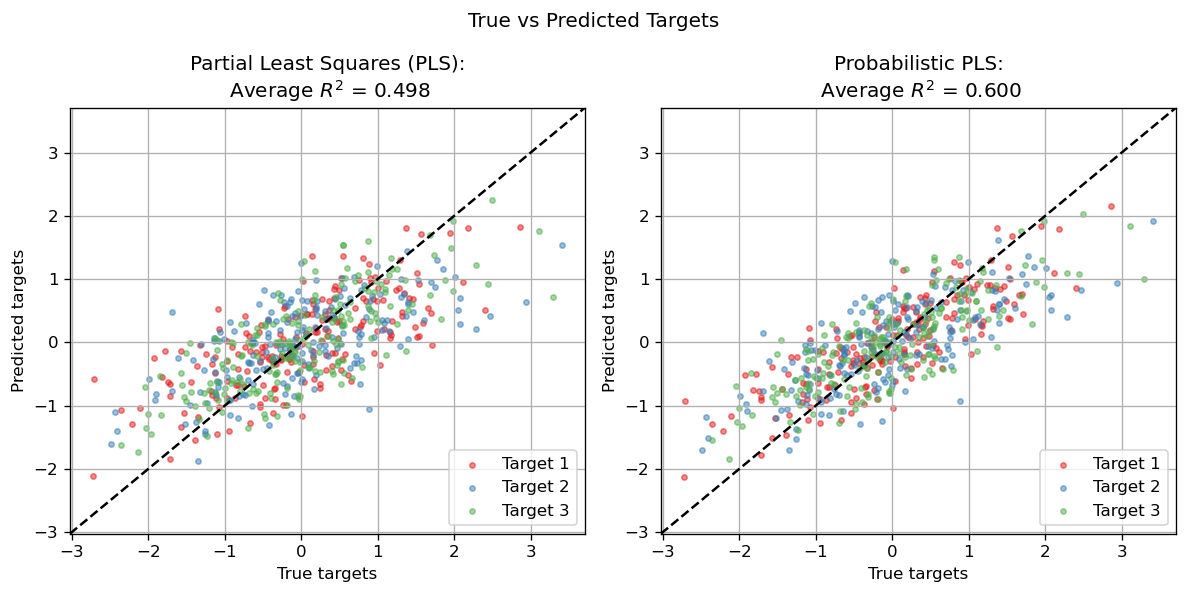

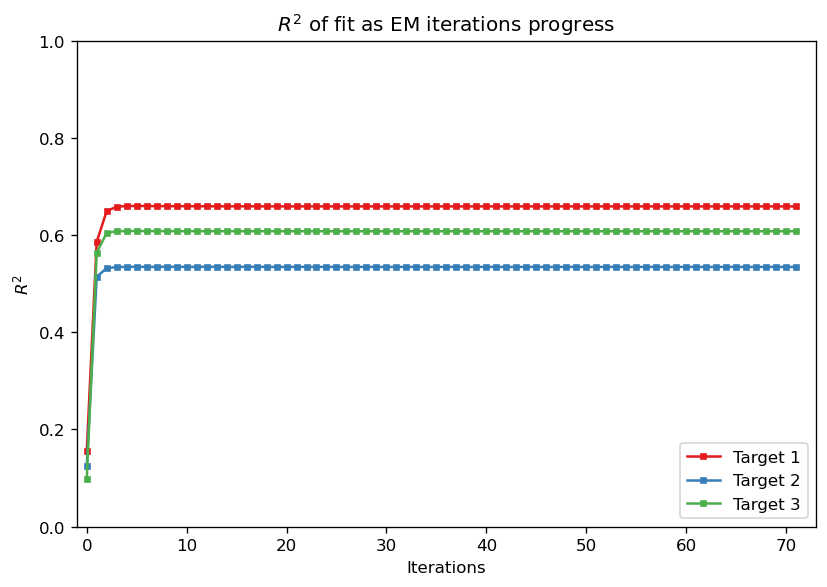

In [16]:
# Visualize comparison between methods
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_fitted_pls_system, Y_fitted_ptfm_system])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls_system[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls_system):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfm_system[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfm_system):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFM
max_iterations = ptfm_system.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfm_system.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Incomplete data: Missing-at-random
When information on the feature or targets is corrupted or incomplete, the standard approach cannot be used to recover the factors at any time period in which there is a missing observation. If these observations can be assumed to be missing at random (i.e., there is no statistical pattern to the missing entries), our approached can be augmented to iteratively correct for these missing observations.

Let $\tau_{t,j}^{(x)}$ be an indicator that equals 1 if the $t$-th observation for feature $j$ is missing, for $t \in \{1, \ldots, T\}$ and $j \in \{1, \ldots, p\}$. Similarly define $\tau_{t,j}^{(y)}$ for targets $j \in \{1, \ldots, q\}$. As the observations are missing-at-random, $\tau_{t,j}^{(x)}$ and $\tau_{t,j}^{(y)}$ are Bernoulli random variables for each observation; i.e., $\Pr(\tau_{t,j}^{(x)}) = p_x$ and $\Pr(\tau_{t,j}^{(y)}) = p_y$ with $p_x, p_y \in [0, 1]$. Therefore, $p_x$ and $p_y$ are the probabilities that any given entry of each matrix is missing, such that these quantities also represent the proportion of missing entries in features $X$ and targets $Y$, respectively.

{'R^2 PLS': array([0.16483811, 0.29595033, 0.45129491]), 'R^2 Probabilistic PLS': array([0.29225318, 0.4544242 , 0.59765193])}


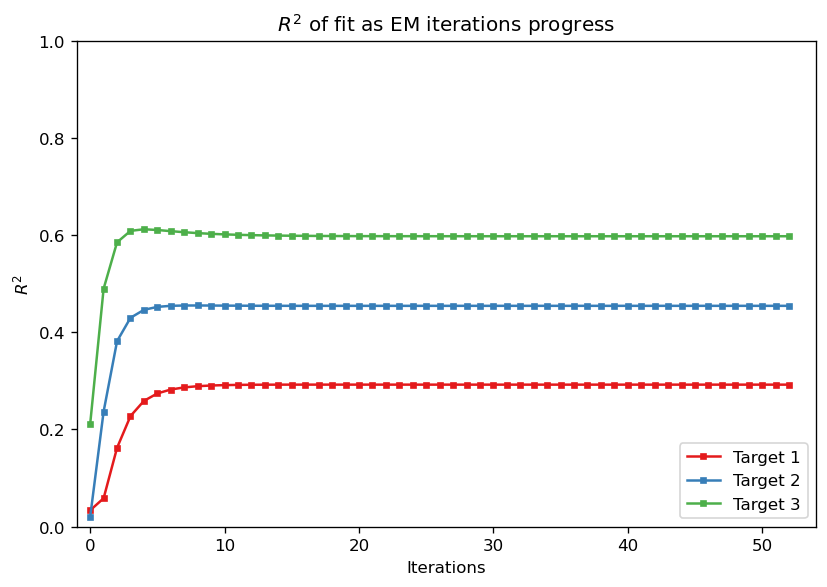

In [17]:
# Generating function
def generate_data_missingatrandom(T, p, q, k, sigma_x, sigma_y,
                                  proportion_x=0.1, proportion_y=None, seed_value=None, return_nan=True):
    """
    Input: 
        T            - Sample size
        p            - Number of features
        q            - Number of targets
        k            - Number of factors (components)
        sigma_x      - Scale of features
        sigma_y      - Scale of targets
        proportion_x - Percentage of missing-at-random observations in feature matrix
        proportion_y - Percentage of missing-at-random observations in target matrix (= proportion_x if None)
        seed_value   - If None, random seed used every time. Otherwise, seed passed to RNG
    Output:
        X - Features (T x p Numpy masked array with fill_value=0.0)
        Y - Targets  (T x q Numpy masked array with fill_value=0.0)
        F - Scores   (T x k matrix)
        P - Loadings of feature equation (p x k matrix)
        Q - Loadings of target equation (q x k matrix)
    """
    # Generate latent variables
    rng = np.random.default_rng(seed=seed_value)
    F = rng.normal(size = [T, k])
    
    # Generate loadings
    P = rng.normal(size = [p, k])
    Q = rng.normal(size = [q, k])
    
    # Generate predictor and response variables with added noise
    X = F @ P.T + rng.normal(scale = sigma_x, size = [T, p])
    Y = F @ Q.T + rng.normal(scale = sigma_y, size = [T, q])
    
    # Select indices to turn into missing observations
    if proportion_y is None:
        proportion_y = proportion_x
    X_size = T * p
    Y_size = T * q
    num_missing_X = int(proportion_x * X_size)
    num_missing_Y = int(proportion_y * Y_size)
    missing_indices_X = rng.choice(X_size, num_missing_X, replace=False, shuffle=False)
    missing_indices_Y = rng.choice(Y_size, num_missing_Y, replace=False, shuffle=False)

    # Transform indices of missing observations to a mask over the data matrices
    missing_indices_X = np.unravel_index(missing_indices_X, [T, p])
    missing_indices_Y = np.unravel_index(missing_indices_Y, [T, q])
    X_missing_mask = np.zeros_like(X, dtype="bool")
    Y_missing_mask = np.zeros_like(Y, dtype="bool")
    X_missing_mask[missing_indices_X] = True
    Y_missing_mask[missing_indices_Y] = True

    # Return the data as Numpy masked objects for easy handling of missing data and imputation
    X = np.ma.MaskedArray(data=X, mask=X_missing_mask, fill_value=0.0)
    Y = np.ma.MaskedArray(data=Y, mask=Y_missing_mask, fill_value=0.0)
    
    return X, Y, F, P, Q

# Simulation control parameters
true_sigma_x, true_sigma_y = 1.0, 1.0
proportion = 0.2
seed_value = None

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true = generate_data_missingatrandom(T, p, q, k, true_sigma_x, true_sigma_y,
                                                        proportion_x=proportion, seed_value=seed_value)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Apply PLS regression (after imputation)
pls = PLSRegression(n_components=k)
pls.fit(X.filled(), Y.filled())
Y_fitted_pls_missing = pls.predict(X.filled())

# Apply our PTFM EM method
ptfm_missing = ptfm.ProbabilisticTFM_Missing(n_components=k)
ptfm_missing.fit(X, Y, standardize = False, track_r2 = True)
Y_fitted_ptfm_missing = ptfm_missing.fitted(X.filled(fill_value=np.nan), Y.filled(fill_value=np.nan), standardize = False)

# Compute R-squared for both models and compare them
r2_pls = r2_score(Y, Y_fitted_pls_missing, multioutput = "raw_values")
r2_ptfm_missing = r2_score(Y, Y_fitted_ptfm_missing, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls, "R^2 Probabilistic PLS": r2_ptfm_missing}
print(r2_results)

# Plot path of R-squared in PTFM
max_iterations = ptfm_missing.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfm_missing.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Incomplete data: Mixed-frequency
Issues of time-varying information availability, complex release schedules, and data revisions can significantly complicate the forecasting of economic phenomena in real time. This issue, generally termed as "mixed-frequency" datasets, has been given extensive attention in the economic literature. Our PTFM approach allows us to recover targeted factors that directly aim to forecast targets available at a lower frequency than the features.

Consider $X^{(m)}$ to be a $T_m \times p$ matrix of features measured at a monthly frequency, and these are used to forecast quarterly targets $Y^{(q)}$, collected into a $T_q \times q$ matrix. As the features are measured at a higher frequency than the targets, $T_q < T_m$. In any given quarter there are a total of three months, so we denote $L = 3$. Our model introduces a set of **latent** monthly targets $Y^{(m)*}$ that aggregates the high-frequency factors (denoted as $F^{(m)}$) for predicting the low-frequency targets. This situation can be represented as
$$
\begin{align*}
    X^{(m)} & = F^{(m)} P' + E_x^{(m)} \\
    Y^{*(m)} & = F^{(m)} Q' + E_y^{(m)} \\
    Y^{(q)} & = \frac{1}{L} \sum_{l=1}^{L} Y^{*(m)}
\end{align*}
$$
We provide functions that generate from this model again using independent normal distributions for $E_x^{(m)}$ and $E_y^{(m)}$.

In [18]:
# Generating function
def generate_data_mixedfrequency(high_frequency_T, low_frequency_T, periods, p, q, k, sigma_x, sigma_y, seed_value=None):
    """
    Input: 
        high_frequency_T - Number of high-frequency observations (size of features)
        low_frequency_T  - Number of low-frequency observations (size of targets)
        periods          - Number of high-frequency periods per low-frequency interval
        p                - Number of features
        q                - Number of targets
        k                - Number of factors (components)
        sigma_x          - Scale of features
        sigma_y          - Scale of targets
        seed_value       - If None, random seed used every time. Otherwise, seed passed to RNG
    Output:
        X        - High-frequency features (high_frequency_T x p matrix)
        Y        - Low-frequency targets  (low_frequency_T x q matrix)
        F        - Scores   (high_frequency_T x k matrix)
        P        - Loadings of feature equation (p x k matrix)
        Q        - Loadings of target equation (q x k matrix)
        Y_latent - Simulated high-frequency targets (high_frequency_T x q matrix)
    """
    # Error checking for time periods: (low_frequency_T - 1) * periods < high_frequency_T <= low_frequency_T * periods
    if (low_frequency_T - 1) * periods >= high_frequency_T or high_frequency_T > low_frequency_T * periods:
        raise AssertionError("Provide arguments such that (low_frequency_T - 1) * periods < high_frequency_T <= low_frequency_T * periods")

    # Generate latent variables
    rng = np.random.default_rng(seed=seed_value)
    F = rng.normal(size = [high_frequency_T, k])
    
    # Generate loadings
    P = rng.normal(size = [p, k])
    Q = rng.normal(size = [q, k])
    
    # Generate predictor and response variables with added noise (at the higher frequency)
    X = F @ P.T + rng.normal(scale = sigma_x, size = [high_frequency_T, p])
    Y_latent = F @ Q.T + rng.normal(scale = sigma_y, size = [high_frequency_T, q])

    # Transform latent targets to observable targets (at lower frequency)
    last_T = periods * (low_frequency_T - 1)
    remainder_T = high_frequency_T - last_T
    Y = np.zeros([low_frequency_T, q])
    for t in range(low_frequency_T - 1):
        row_index = range(t * periods, (t+1) * periods)
        Y[t] = np.sum(Y_latent[row_index], axis = 0)
    row_index = range(last_T, (low_frequency_T - 1) * periods + remainder_T)
    Y[low_frequency_T - 1] = np.sum(Y_latent[row_index], axis = 0)
    
    return X, Y, F, P, Q, Y_latent

# Simulation control parameters
periods = 3
high_frequency_T = T
low_frequency_T = int(np.ceil(high_frequency_T / periods))
true_sigma_x, true_sigma_y = 1.0, 1.0
seed_value = None

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true, Y_latent = generate_data_mixedfrequency(high_frequency_T, low_frequency_T, periods, p, q, k,
                                                                 true_sigma_x, true_sigma_y, seed_value)

# Apply our PTFM EM method
ptfm_mixedfrequency = ptfm.ProbabilisticTFM_MixedFrequency(n_components=k)
ptfm_mixedfrequency.fit(X, Y, periods, standardize = False, track_r2 = True)
Y_fitted_ptfm_mixedfrequency = ptfm_mixedfrequency.fitted(X, Y, periods, standardize = False)

# Compute R-squared
r2_ptfm_mixedfrequency = r2_score(Y, Y_fitted_ptfm_mixedfrequency, multioutput = "raw_values")
print(r2_ptfm_mixedfrequency)

[0.84132078 0.52179252 0.67017285]


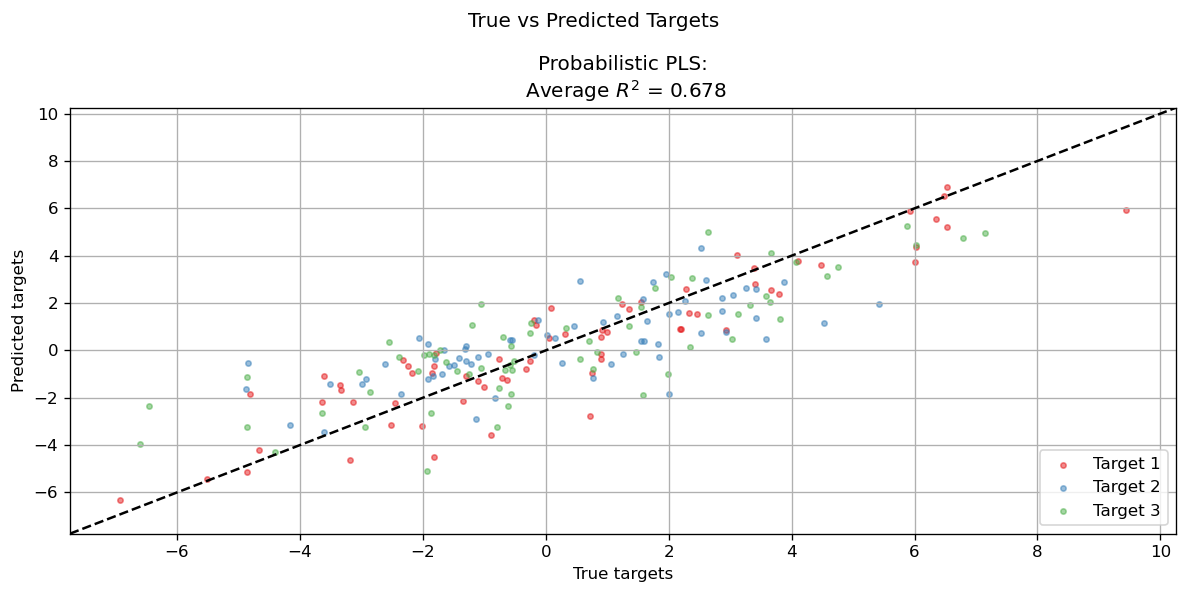

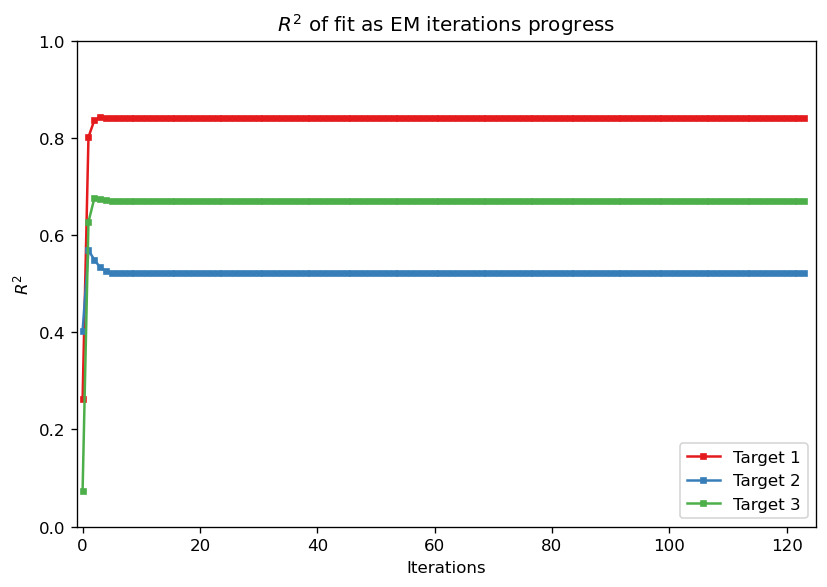

In [19]:
# Visualization of true vs. tredicted responses
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_fitted_ptfm_mixedfrequency])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# Probabilistic PLS
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfm_mixedfrequency[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfm_mixedfrequency):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFM
max_iterations = ptfm_mixedfrequency.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfm_mixedfrequency.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Stochastic volatility
In economic applications, it is standard to allow for the volatility of both feature and target variables involved to experience persistence across time. To this end, we can allow for $E_{X, t} \sim \text{Normal}(0_p, \sigma_{x, t}^2 I_p)$ and $E_{Y, t} \sim \text{Normal}(0_q, \sigma_{y, t}^2 I_p)$ where $I_n$ is an identity matrix of order $n$. We provide functions that generate $X$ and $Y$ assuming that initial scales $\sigma_{x, 0}^2$ and $\sigma_{y, 0}^2$ are updated according to the exponentially weighted moving average (EWMA) process:
$$
\begin{align*}
    \sigma_{x, t}^2 & = \lambda_x \sigma_{x, t-1}^2 + (1 - \lambda_x) \eta_{x, t}^2 \\
    \sigma_{y, t}^2 & = \lambda_y \sigma_{y, t-1}^2 + (1 - \lambda_y) \eta_{y, t}^2
\end{align*}
$$
where $\eta_{x, t} \sim \text{Normal}(0, \sigma_{x, 0}^2)$ and $\eta_{y, t} \sim \text{Normal}(0, \sigma_{y, 0}^2)$ are independent white noise processes and $\lambda_x$ and $\lambda_y$ are smoothing parameters.

In [20]:
# Data generation function with known stochastic volatility
def generate_data_stochasticvolatility(T, p, q, k, sigma2_x0=0.5, sigma2_y0=0.5, lambda_x=0.9, lambda_y=0.9, seed_value=None):
    """
    Input: 
        T          - Sample size
        p          - Number of features
        q          - Number of targets
        k          - Number of factors (components)
        sigma2_x0  - Initial variance of features and variance of moving average component of feature volatility
        sigma2_y0  - Initial variance of targets and variance of moving average component of target volatility
        lambda_x   - Smoothing parameter for generating stochastic volatility in features according to EWMA
        lambda_y   - Smoothing parameter for generating stochastic volatility in targets according to EWMA
        seed_value - If None, random seed used every time. Otherwise, seed passed to RNG
    Output:
        X        - Features (T x p matrix, masked array with fill_value=0.0 if return_nan = False)
        Y        - Targets  (T x q matrix, masked array with fill_value=0.0 if return_nan = False)
        F        - Scores   (T x k matrix)
        P        - Loadings of feature equation (p x k matrix)
        Q        - Loadings of target equation (q x k matrix)
        sigma2_x - Vector of variances for features (T-dimensional vector)
        sigma2_y - Vector of variances for targets (T-dimensional vector)
    """
    # Generate latent variables
    rng = np.random.default_rng(seed=seed_value)
    F = rng.normal(size = [T, k])
    
    # Generate loadings
    P = rng.normal(size = [p, k])
    Q = rng.normal(size = [q, k])
    
    # Generate volatilities according to a Exponentially Weighted Moving Average (EWMA)
    sigma2_x = np.zeros(T)
    sigma2_y = np.zeros(T)
    sigma2_x[0], sigma2_y[0] = sigma2_x0, sigma2_y0  # Initial volatilities
    eta_x_squared = rng.normal(scale = np.sqrt(sigma2_x0), size = T-1) ** 2
    eta_y_squared = rng.normal(scale = np.sqrt(sigma2_y0), size = T-1) ** 2
    for t in range(1, T):
        sigma2_x[t] = (1 - lambda_x) * eta_x_squared[t-1] + lambda_x * sigma2_x[t-1]
        sigma2_y[t] = (1 - lambda_y) * eta_y_squared[t-1] + lambda_y * sigma2_y[t-1]
    
    # Generate synthetic X and Y data with time-varying volatility
    X = F @ P.T + rng.normal(scale=np.sqrt(sigma2_x)[:, np.newaxis], size=[T, p])
    Y = F @ Q.T + rng.normal(scale=np.sqrt(sigma2_y)[:, np.newaxis], size=[T, q])

    return X, Y, F, P, Q, sigma2_x, sigma2_y

# Simulation parameters
sigma2_x0, sigma2_y0 = 0.5, 0.5  # Initial variances (also the variance of the moving average component in EWMA generation)
lambda_x, lambda_y = 0.94, 0.94  # EWMA smoothing parameters for X and Y
rng_seed = 42

# Generate synthetic data
X, Y, _, P_true, Q_true, true_sigma2_x, true_sigma2_y = generate_data_stochasticvolatility(T, p, q, k, sigma2_x0, sigma2_y0, lambda_x, lambda_y, rng_seed)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls = pls.predict(X)

# Create and train the ProbabilisticTFM model with stochastic volatility
ptfm_sv_model = ptfm.ProbabilisticTFM_StochasticVolatility(n_components=k)
ptfm_sv_model.fit(X, Y, standardize=False, track_r2=True, ewma_lambda_x=lambda_x,ewma_lambda_y=lambda_y)
Y_fitted_ptfm_sv = ptfm_sv_model.fitted(X, Y, standardize = False)

# Create and trend the model without taking into account SV for comparison
ptfm_model = ptfm.ProbabilisticTFM(n_components=k)
ptfm_model.fit(X, Y, standardize=True, track_r2=True)
Y_fitted_ptfm_simple = ptfm_model.fitted(X, Y, standardize = False)

# Compute R-squared for all models and compare them
r2_pls = r2_score(Y, Y_fitted_pls, multioutput = "raw_values")
r2_ptfm_sv = r2_score(Y, Y_fitted_ptfm_sv, multioutput = "raw_values")
r2_ptfm_simple = r2_score(Y, Y_fitted_ptfm_simple, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls, "R^2 PTFM SV": r2_ptfm_sv, "R^2 PTFM Simple": r2_ptfm_simple}
print(r2_results)

{'R^2 PLS': array([0.40212482, 0.79865189, 0.60181084]), 'R^2 PTFM SV': array([0.50081179, 0.86812874, 0.66407244]), 'R^2 PTFM Simple': array([0.47421857, 0.86366209, 0.54797662])}


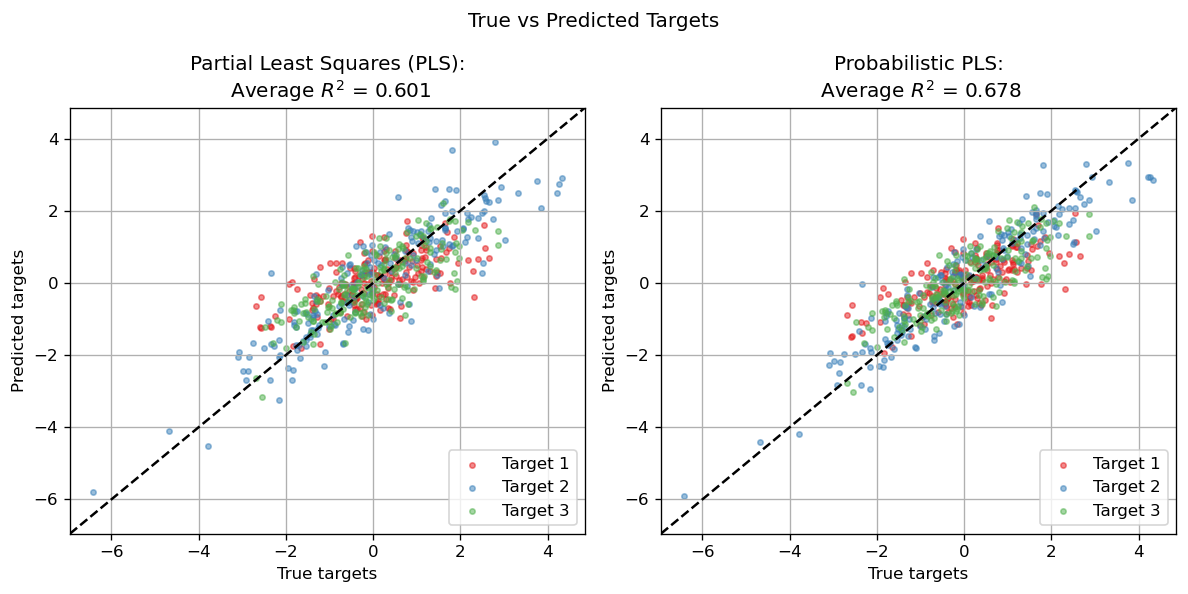

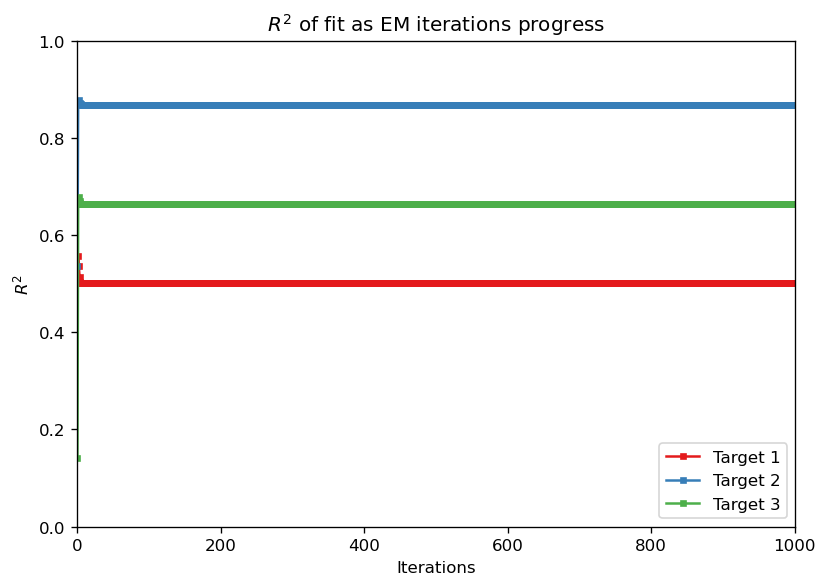

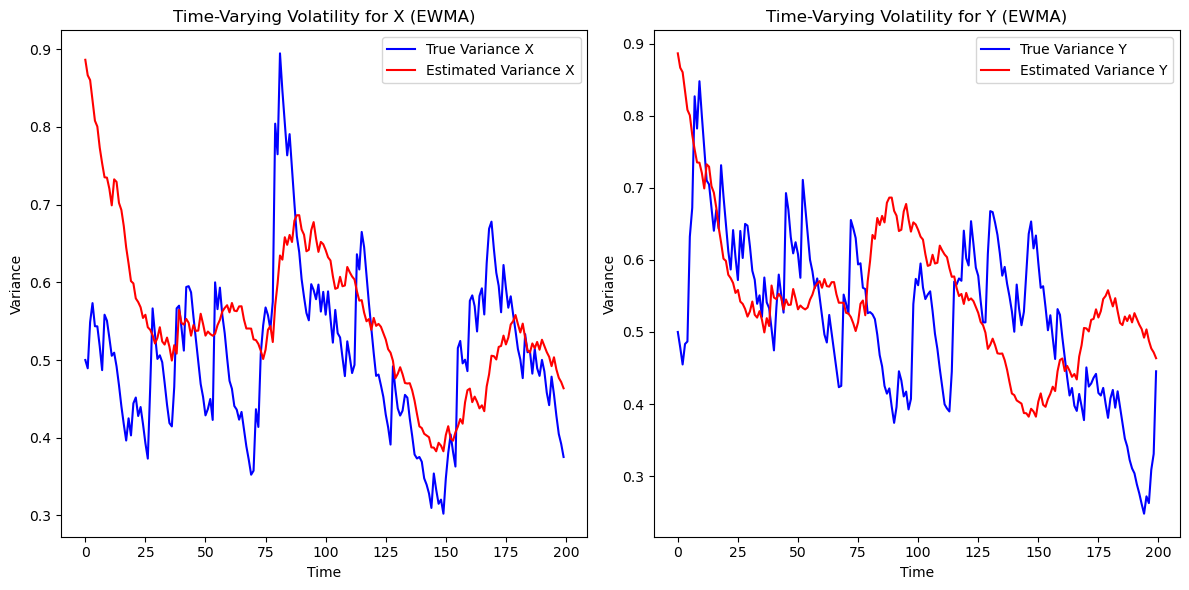

In [21]:
# Visualize comparison between methods
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_fitted_pls, Y_fitted_ptfm_sv])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS with Stochastic Volatility
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfm_sv[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfm_sv):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFM
max_iterations = ptfm_sv_model.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfm_sv_model.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Fetch the estimated volatilities
estimated_sigma2_x = ptfm_sv_model.sigma2_x  # Estimated time-varying volatility for X (EWMA-based)
estimated_sigma2_y = ptfm_sv_model.sigma2_y  # Estimated time-varying volatility for Y (EWMA-based)

# Plot estimated vs true volatilities
plt.figure(figsize=(12, 6))

# Plot for X
plt.subplot(1, 2, 1)
plt.plot(true_sigma2_x, label="True Variance X", color="blue")
plt.plot(estimated_sigma2_x, label="Estimated Variance X", color="red")
plt.title("Time-Varying Volatility for X (EWMA)")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.legend()

# Plot for Y
plt.subplot(1, 2, 2)
plt.plot(true_sigma2_y, label="True Variance Y", color="blue")
plt.plot(estimated_sigma2_x, label="Estimated Variance Y", color="red")
plt.title("Time-Varying Volatility for Y (EWMA)")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()

## Factor Dynamics
A final extension that is of particular interest to economic data is to allow for dynamics or persistence in the factors. As the recovered components are usually interpreted as fundamental drivers of business cycles and co-movements between economic series, it is natural to allow for these fundamentals to exhibit dynamic persistence across time. To this end, at each time $t \in \{1, \ldots, T\}$, we augment our initial model equations to include a dynamic equation for the factors:
$$
\begin{align*}
x_t & = P f_t + e_{x, t} \\
y_t & = Q f_t + e_{y, t} \\
f_t & = A f_{t-1} + v_t
\end{align*}
$$
We include the dynamic coefficients $A$ ($k \times k$ matrix) and initial conditions $f_0$ ($k$-dimensional vector) as additional parameters to estimate in our EM algorithm. We continue to assume $e_{x, t}$ and $e_{y, t}$ to be uncorrelated at each point in time with a fixed variance $\sigma_{x}^2$ and $\sigma_{y}^2$, respectively. Additionally, these disturbances are also assumed uncorrelated to the white noise process $v_t$ that has mean $0$ and variance $V_F$. Note that this variance is the same as the prior variance before, as this quantity is not identified from the data (unless additional identification restrictions are imposed in the system).

In [24]:
# Generating function
def generate_data_dynamicfactors(T, p, q, k, sigma_x, sigma_y, A, f0, seed_value=None):
    """
    Input: 
        T          - Sample size
        p          - Number of features
        q          - Number of targets
        k          - Number of factors (components)
        sigma_x    - Scale of features
        sigma_y    - Scale of targets
        A          - Coefficients used to generate dynamics (k x k matrix)
        f0         - Initial condition used to generate dynamics (length k vector)
        seed_value - If None, random seed used every time. Otherwise, seed passed to RNG
    Output:
        X - Features (T x p matrix)
        Y - Targets  (T x q matrix)
        F - Scores   (T x k matrix)
        P - Loadings of feature equation (p x k matrix)
        Q - Loadings of target equation (q x k matrix)
    """
    # Generate latent variables
    rng = np.random.default_rng(seed=seed_value)
    F = np.zeros([T, k])
    v = rng.normal(size = [T, k])
    F[0] = A @ f0 + v[0]
    for t in range(1, T):
        F[t] = A @ F[t-1] + v[t]
    
    # Generate loadings
    P = rng.normal(size = [p, k])
    Q = rng.normal(size = [q, k])
    
    # Generate predictor and response variables with added noise
    X = F @ P.T + rng.normal(scale = sigma_x, size = [T, p])
    Y = F @ Q.T + rng.normal(scale = sigma_y, size = [T, q])
    
    return X, Y, F, P, Q

# Simulation control parameters
true_sigma_x, true_sigma_y = 1.0, 1.0
A_true = np.diag([0.9, 0.5])
f0_true = np.zeros(k)
seed_value = None

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true = generate_data_dynamicfactors(T, p, q, k, true_sigma_x, true_sigma_y, A_true, f0_true, seed_value)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls_dynamic = pls.predict(X)

# Apply our PTFM EM method with AR(1) factor dynamics
ptfm_dynamic = ptfm.ProbabilisticTFM_DynamicFactors(n_components=k)
ptfm_dynamic.fit(X, Y, standardize = False, track_r2 = True)
Y_fitted_ptfm_dynamic = ptfm_dynamic.fitted(X, Y, standardize = False)

# Compute R-squared for both models and compare them
r2_pls_dynamic = r2_score(Y, Y_fitted_pls_dynamic, multioutput = "raw_values")
r2_ptfm_dynamic = r2_score(Y, Y_fitted_ptfm_dynamic, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls_dynamic, "R^2 Probabilistic PLS": r2_ptfm_dynamic}
print(r2_results)

{'R^2 PLS': array([0.7987687 , 0.70212613, 0.81745385]), 'R^2 Probabilistic PLS': array([0.84228174, 0.74425339, 0.86622603])}


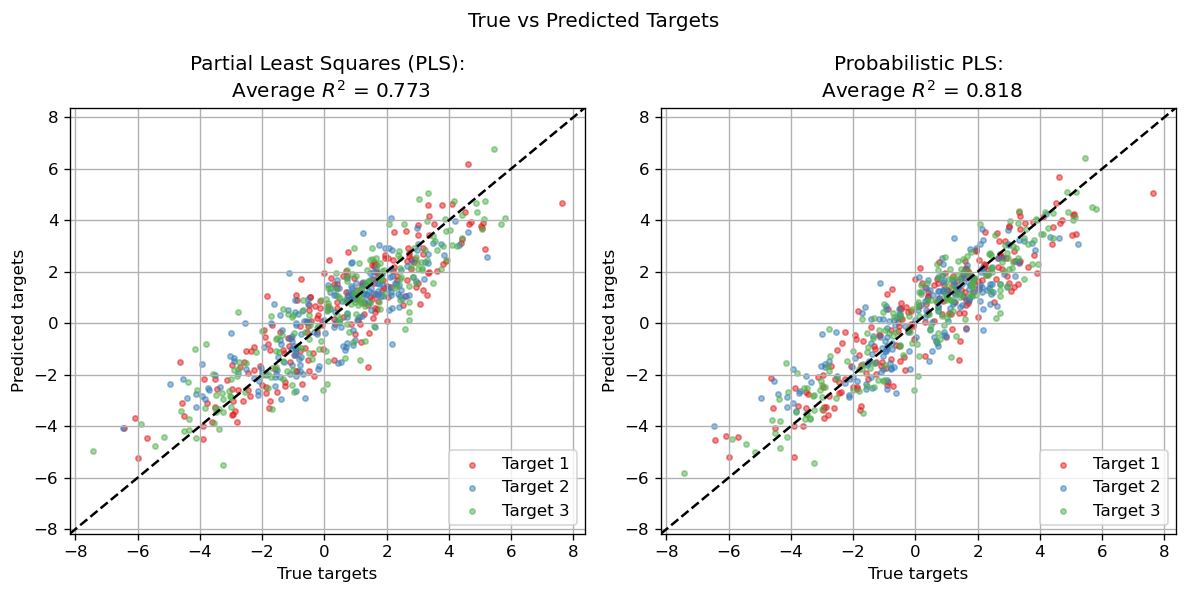

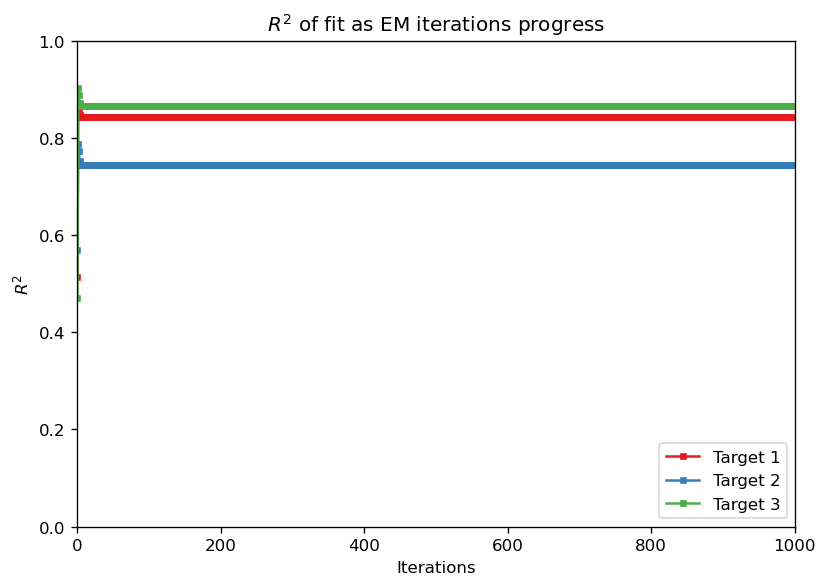

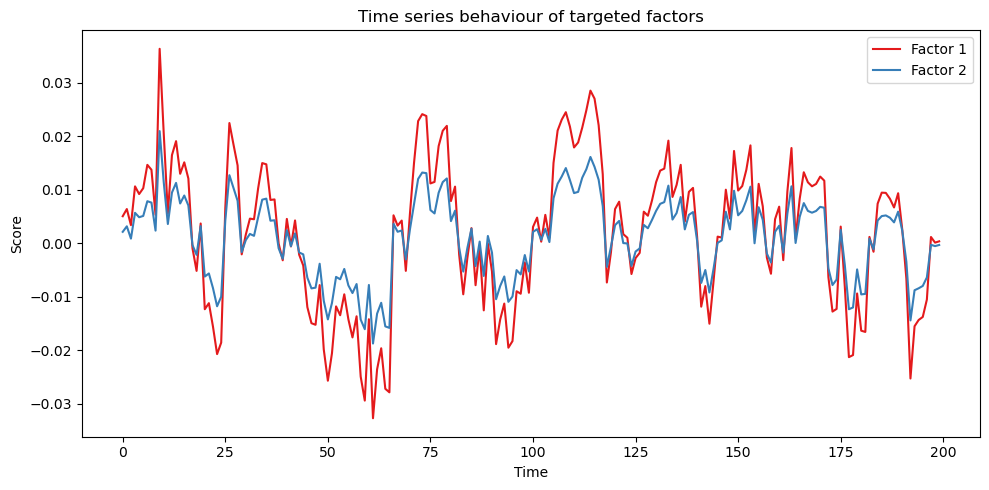

In [25]:
# Visualize comparison between methods
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_fitted_pls_dynamic, Y_fitted_ptfm_dynamic])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls_dynamic[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls_dynamic):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfm_dynamic[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfm_dynamic):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFM
max_iterations = ptfm_dynamic.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfm_dynamic.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Time series plots of recovered factors
factor_names = ["Factor " + str(j+1) for j in range(k)]
recovered_factors = ptfm_dynamic.factors
plt.figure(figsize=(10, 5))
for j in range(k):
    plt.plot(recovered_factors[:, j], color=colors(j), label=factor_names[j])
plt.title("Time series behaviour of targeted factors")
plt.xlabel("Time")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()